# DETECTING PSYCHOLOGICAL STATE OF CHILDREN BY HTP DRAWINGS

In [94]:
import os
import pandas as pd
import fitz 
from PIL import Image
import shutil
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import cv2
from sklearn.utils import shuffle

from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from collections import Counter
import shutil
import subprocess

from quickdraw import QuickDrawDataGroup
from quickdraw import QuickDrawData

import tensorflow as tf
import keras
import keras.utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing import image
import keras.utils as image

from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix


from keras import layers

# TF imports related to tf.data preprocessing
from tensorflow import clip_by_value
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import random as tf_random

import imgaug.augmenters as iaa
import zipfile
import os
import json
from pycocotools.coco import COCO

## Load Dataset

In [2]:
dataset_folder = 'HTPDataset'

In [3]:
pdf_files = [f for f in os.listdir(dataset_folder) if f.endswith('.pdf')]
print("List of PDF files:")
for pdf_file in pdf_files:
    print(pdf_file)

List of PDF files:
201802_MBC.pdf
522019_GY.pdf
202016_NEŞ.pdf
201720_ERD.pdf
142019_BST.pdf
201664_MMŞ.pdf
152017_MBT.pdf
532019_MT.pdf
302016_YG.pdf
992016_OFB.pdf
992017_EK.pdf
222016_KAM.pdf
402016_NG.pdf
212016_MG.pdf
162019_EA.pdf
562019_YD.pdf
242016_ZK.pdf
262016_BGÖ.pdf
552017_KYA.pdf
122018_AST.pdf
201755_GA.pdf
582019_ZD.pdf
132018_BMY.pdf
142018_CEÜ.pdf
582017_RZİ.pdf
201759_BK.pdf
512018_FZA.pdf
201803_SD.pdf
162017_MK.pdf
192019_ES.pdf
542018_RRA.pdf
201839_MŞY.pdf
192016_ENÇ.pdf
112018_AG.pdf
132019_BA.pdf
162016_EMA.pdf
122019_AAA.pdf
172016_AK.pdf
562017_LÇ.pdf
532017_FŞK.pdf
592019_MB.pdf
112016_YG.pdf
252016_EDB.pdf
172019_EB.pdf
201809_OMB.pdf
222019_ATS.pdf
152019_CEÖ.pdf
122017_DF.pdf
182019_EHT.pdf
152016_HBK.pdf
282016_OMB.pdf
512019_FAG.pdf
201815_EBK.pdf
412016_Nİ.pdf
232019_BBG.pdf
472019_ZAA.pdf
992018_ENŞ.pdf
102016_EY.pdf
552019_RE.pdf
312016_AB.pdf
162018_EA.pdf
201738_AŞ.pdf
982018_YEK.pdf
522018_HP.pdf
142017_EM.pdf
542019_MÖ.pdf
532018_HC

In [4]:
pdf_page_counts = {}
for pdf_file in pdf_files:
    pdf_path = os.path.join(dataset_folder, pdf_file)
    pdf_document = fitz.open(pdf_path)
    num_pages = pdf_document.page_count
    pdf_page_counts[pdf_file] = num_pages
    pdf_document.close()
print("Number of pages in each PDF file:")
for pdf_file, num_pages in pdf_page_counts.items():
    print(f"{pdf_file}: {num_pages} pages")

Number of pages in each PDF file:
201802_MBC.pdf: 5 pages
522019_GY.pdf: 5 pages
202016_NEŞ.pdf: 5 pages
201720_ERD.pdf: 5 pages
142019_BST.pdf: 5 pages
201664_MMŞ.pdf: 10 pages
152017_MBT.pdf: 10 pages
532019_MT.pdf: 5 pages
302016_YG.pdf: 4 pages
992016_OFB.pdf: 4 pages
992017_EK.pdf: 6 pages
222016_KAM.pdf: 5 pages
402016_NG.pdf: 5 pages
212016_MG.pdf: 5 pages
162019_EA.pdf: 5 pages
562019_YD.pdf: 5 pages
242016_ZK.pdf: 5 pages
262016_BGÖ.pdf: 5 pages
552017_KYA.pdf: 3 pages
122018_AST.pdf: 5 pages
201755_GA.pdf: 7 pages
582019_ZD.pdf: 5 pages
132018_BMY.pdf: 5 pages
142018_CEÜ.pdf: 5 pages
582017_RZİ.pdf: 5 pages
201759_BK.pdf: 5 pages
512018_FZA.pdf: 5 pages
201803_SD.pdf: 5 pages
162017_MK.pdf: 8 pages
192019_ES.pdf: 5 pages
542018_RRA.pdf: 5 pages
201839_MŞY.pdf: 6 pages
192016_ENÇ.pdf: 5 pages
112018_AG.pdf: 5 pages
132019_BA.pdf: 5 pages
162016_EMA.pdf: 5 pages
122019_AAA.pdf: 5 pages
172016_AK.pdf: 5 pages
562017_LÇ.pdf: 4 pages
532017_FŞK.pdf: 5 pages
592019_MB.pdf:

## Dataset Preparation

In [5]:
img_dataset = 'HTPImages'
if not os.path.exists(img_dataset):
    os.makedirs(img_dataset)

In [6]:
pdf_files = [f for f in os.listdir(dataset_folder) if f.endswith('.pdf')]

for pdf_file in pdf_files:
    pdf_path = os.path.join(dataset_folder, pdf_file)
    pdf_document = fitz.open(pdf_path)
    
    base_name = os.path.splitext(pdf_file)[0]
    
    for page_num in range(pdf_document.page_count):
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap()
        
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        img_filename = f"{base_name}_{page_num + 1}.jpg"
        img_path = os.path.join(img_dataset, img_filename)
        img.save(img_path, "JPEG")
    
    pdf_document.close()

print("PDF to image conversion completed.")

PDF to image conversion completed.


In [7]:
def extract_metadata(filename):
    parts = os.path.splitext(filename)[0].split('_')
    id = parts[0]
    patient_name = '_'.join(parts[1:-1])
    page_number = parts[-1]
    return id, patient_name, page_number

image_files = [f for f in os.listdir(img_dataset) if f.endswith('.jpg')]

In [8]:
'''
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    img_filename = image_files[i]
    img_path = os.path.join(img_dataset, img_filename)
    img = Image.open(img_path)
    
    id, patient_name, page_number = extract_metadata(img_filename)
    
    axes[i].imshow(img)
    axes[i].set_title(f"ID: {id}\nPatient Name: {patient_name}\nPage Number: {page_number}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
'''

'\nnum_samples = 5\nfig, axes = plt.subplots(1, num_samples, figsize=(15, 5))\n\nfor i in range(num_samples):\n    img_filename = image_files[i]\n    img_path = os.path.join(img_dataset, img_filename)\n    img = Image.open(img_path)\n    \n    id, patient_name, page_number = extract_metadata(img_filename)\n    \n    axes[i].imshow(img)\n    axes[i].set_title(f"ID: {id}\nPatient Name: {patient_name}\nPage Number: {page_number}")\n    axes[i].axis(\'off\')\n\nplt.tight_layout()\nplt.show()\n'

In [9]:
ids = []
patient_names = []
page_numbers = []
patient_ids = []

for img_filename in image_files:
    id, patient_name, page_number = extract_metadata(img_filename)
    ids.append(id)
    patient_names.append(patient_name)
    page_numbers.append(page_number)
    patient_ids.append(f"{id}_{patient_name}")

df = pd.DataFrame({
    'image_file': image_files, 
    'ID': ids,
    'patient_name': patient_names,
    'page_number': page_numbers,
    'patient_Identifier': patient_ids
})

unique_patient_ids = {identifier: idx+1 for idx, identifier in enumerate(sorted(set(patient_ids)))}
df['patient_ID'] = df['patient_Identifier'].map(unique_patient_ids)
df = df.drop(columns=['patient_Identifier'])

df

,image_file,ID,patient_name,page_number,patient_ID
0,992016_OFB_1.jpg,992016,OFB,1,81
1,512017_ES_3.jpg,512017,ES,3,61
2,201931_REG_2.jpg,201931,REG,2,44
3,122019_AAA_1.jpg,122019,AAA,1,8
4,202016_NEŞ_1.jpg,202016,NEŞ,1,45
...,...,...,...,...,...
445,201759_BK_3.jpg,201759,BK,3,35
446,512020_ARÖ_4.jpg,512020,ARÖ,4,64
447,522018_HP_5.jpg,522018,HP,5,65
448,112016_YG_5.jpg,112016,YG,5,2


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_file    450 non-null    object
 1   ID            450 non-null    object
 2   patient_name  450 non-null    object
 3   page_number   450 non-null    object
 4   patient_ID    450 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 17.7+ KB


In [11]:
for img_filename in image_files:
    old_path = os.path.join(img_dataset, img_filename)
    id, patient_name, page_number = extract_metadata(img_filename)
    new_filename = f"{df[df['image_file'] == img_filename]['patient_ID'].iloc[0]}_{page_number}.jpg"
    new_path = os.path.join(img_dataset, new_filename)
    os.rename(old_path, new_path)
    df.loc[df['image_file'] == img_filename, 'image_file'] = new_filename

df

,image_file,ID,patient_name,page_number,patient_ID
0,81_1.jpg,992016,OFB,1,81
1,61_3.jpg,512017,ES,3,61
2,44_2.jpg,201931,REG,2,44
3,8_1.jpg,122019,AAA,1,8
4,45_1.jpg,202016,NEŞ,1,45
...,...,...,...,...,...
445,35_3.jpg,201759,BK,3,35
446,64_4.jpg,512020,ARÖ,4,64
447,65_5.jpg,522018,HP,5,65
448,2_5.jpg,112016,YG,5,2


In [12]:
xlsx_path = 'HTPDataset/patient_info.xlsx'
df_excel = pd.read_excel(xlsx_path)
df_excel.head()

,ID,Initials,Gen,Age,CB_Ex_R,CB_Anx_R,CB_Dep_R,WISC_TOZP_SP,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,102016,EY,1,7,12.0,4.0,5.0,90.0,NaN,NaN,We consider only children with IQ equal or abo...
1,112016,YG,0,9,3.0,5.0,3.0,NaN,NaN,NaN,We consider only school age children: 6-12 yea...
2,112018,AG,1,8,4.0,8.0,7.0,62.0,Low IQ: ignore the child,NaN,NaN
3,112019,AA,1,11,10.0,3.0,1.0,88.0,NaN,NaN,NaN
4,122016,TO,0,8,6.0,3.0,6.0,136.0,NaN,NaN,NaN


In [13]:
df_excel = df_excel.drop(columns=['Initials','Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])
df_excel = df_excel.rename(columns={'Gen': 'sex', 'Age': 'age', 'CB_Ex_R': 'externalising_score', 'CB_Anx_R':'anxious_score', 'CB_Dep_R':'depressive_score', 'WISC_TOZP_SP':'iq_score'})
df_excel

,ID,sex,age,externalising_score,anxious_score,depressive_score,iq_score
0,102016,1,7,12.0,4.0,5.0,90.0
1,112016,0,9,3.0,5.0,3.0,NaN
2,112018,1,8,4.0,8.0,7.0,62.0
3,112019,1,11,10.0,3.0,1.0,88.0
4,122016,0,8,6.0,3.0,6.0,136.0
...,...,...,...,...,...,...,...
79,982018,1,6,9.0,8.0,5.0,85.0
80,992016,1,6,10.0,7.0,4.0,96.0
81,992017,1,7,5.0,2.0,1.0,151.0
82,992018,0,10,4.0,4.0,0.0,65.0


In [14]:
df

,image_file,ID,patient_name,page_number,patient_ID
0,81_1.jpg,992016,OFB,1,81
1,61_3.jpg,512017,ES,3,61
2,44_2.jpg,201931,REG,2,44
3,8_1.jpg,122019,AAA,1,8
4,45_1.jpg,202016,NEŞ,1,45
...,...,...,...,...,...
445,35_3.jpg,201759,BK,3,35
446,64_4.jpg,512020,ARÖ,4,64
447,65_5.jpg,522018,HP,5,65
448,2_5.jpg,112016,YG,5,2


In [15]:
df_excel['ID'] = df_excel['ID'].astype(str)
df['ID'] = df['ID'].astype(str)
df = pd.merge(df, df_excel, on='ID', how='left')
df = df.ffill()
df = df.drop(columns=['ID'])
df

,image_file,patient_name,page_number,patient_ID,sex,age,externalising_score,anxious_score,depressive_score,iq_score
0,81_1.jpg,OFB,1,81,1,6,10.0,7.0,4.0,96.0
1,61_3.jpg,ES,3,61,1,6,10.0,7.0,4.0,116.0
2,44_2.jpg,REG,2,44,1,7,27.0,17.0,6.0,49.0
3,8_1.jpg,AAA,1,8,1,6,9.0,5.0,3.0,121.0
4,45_1.jpg,NEŞ,1,45,0,8,3.0,6.0,2.0,96.0
...,...,...,...,...,...,...,...,...,...,...
445,35_3.jpg,BK,3,35,1,12,16.0,8.0,3.0,93.0
446,64_4.jpg,ARÖ,4,64,1,13,6.0,6.0,3.0,85.0
447,65_5.jpg,HP,5,65,0,7,10.0,7.0,1.0,115.0
448,2_5.jpg,YG,5,2,0,9,3.0,5.0,3.0,115.0


## Dataset Visualisation

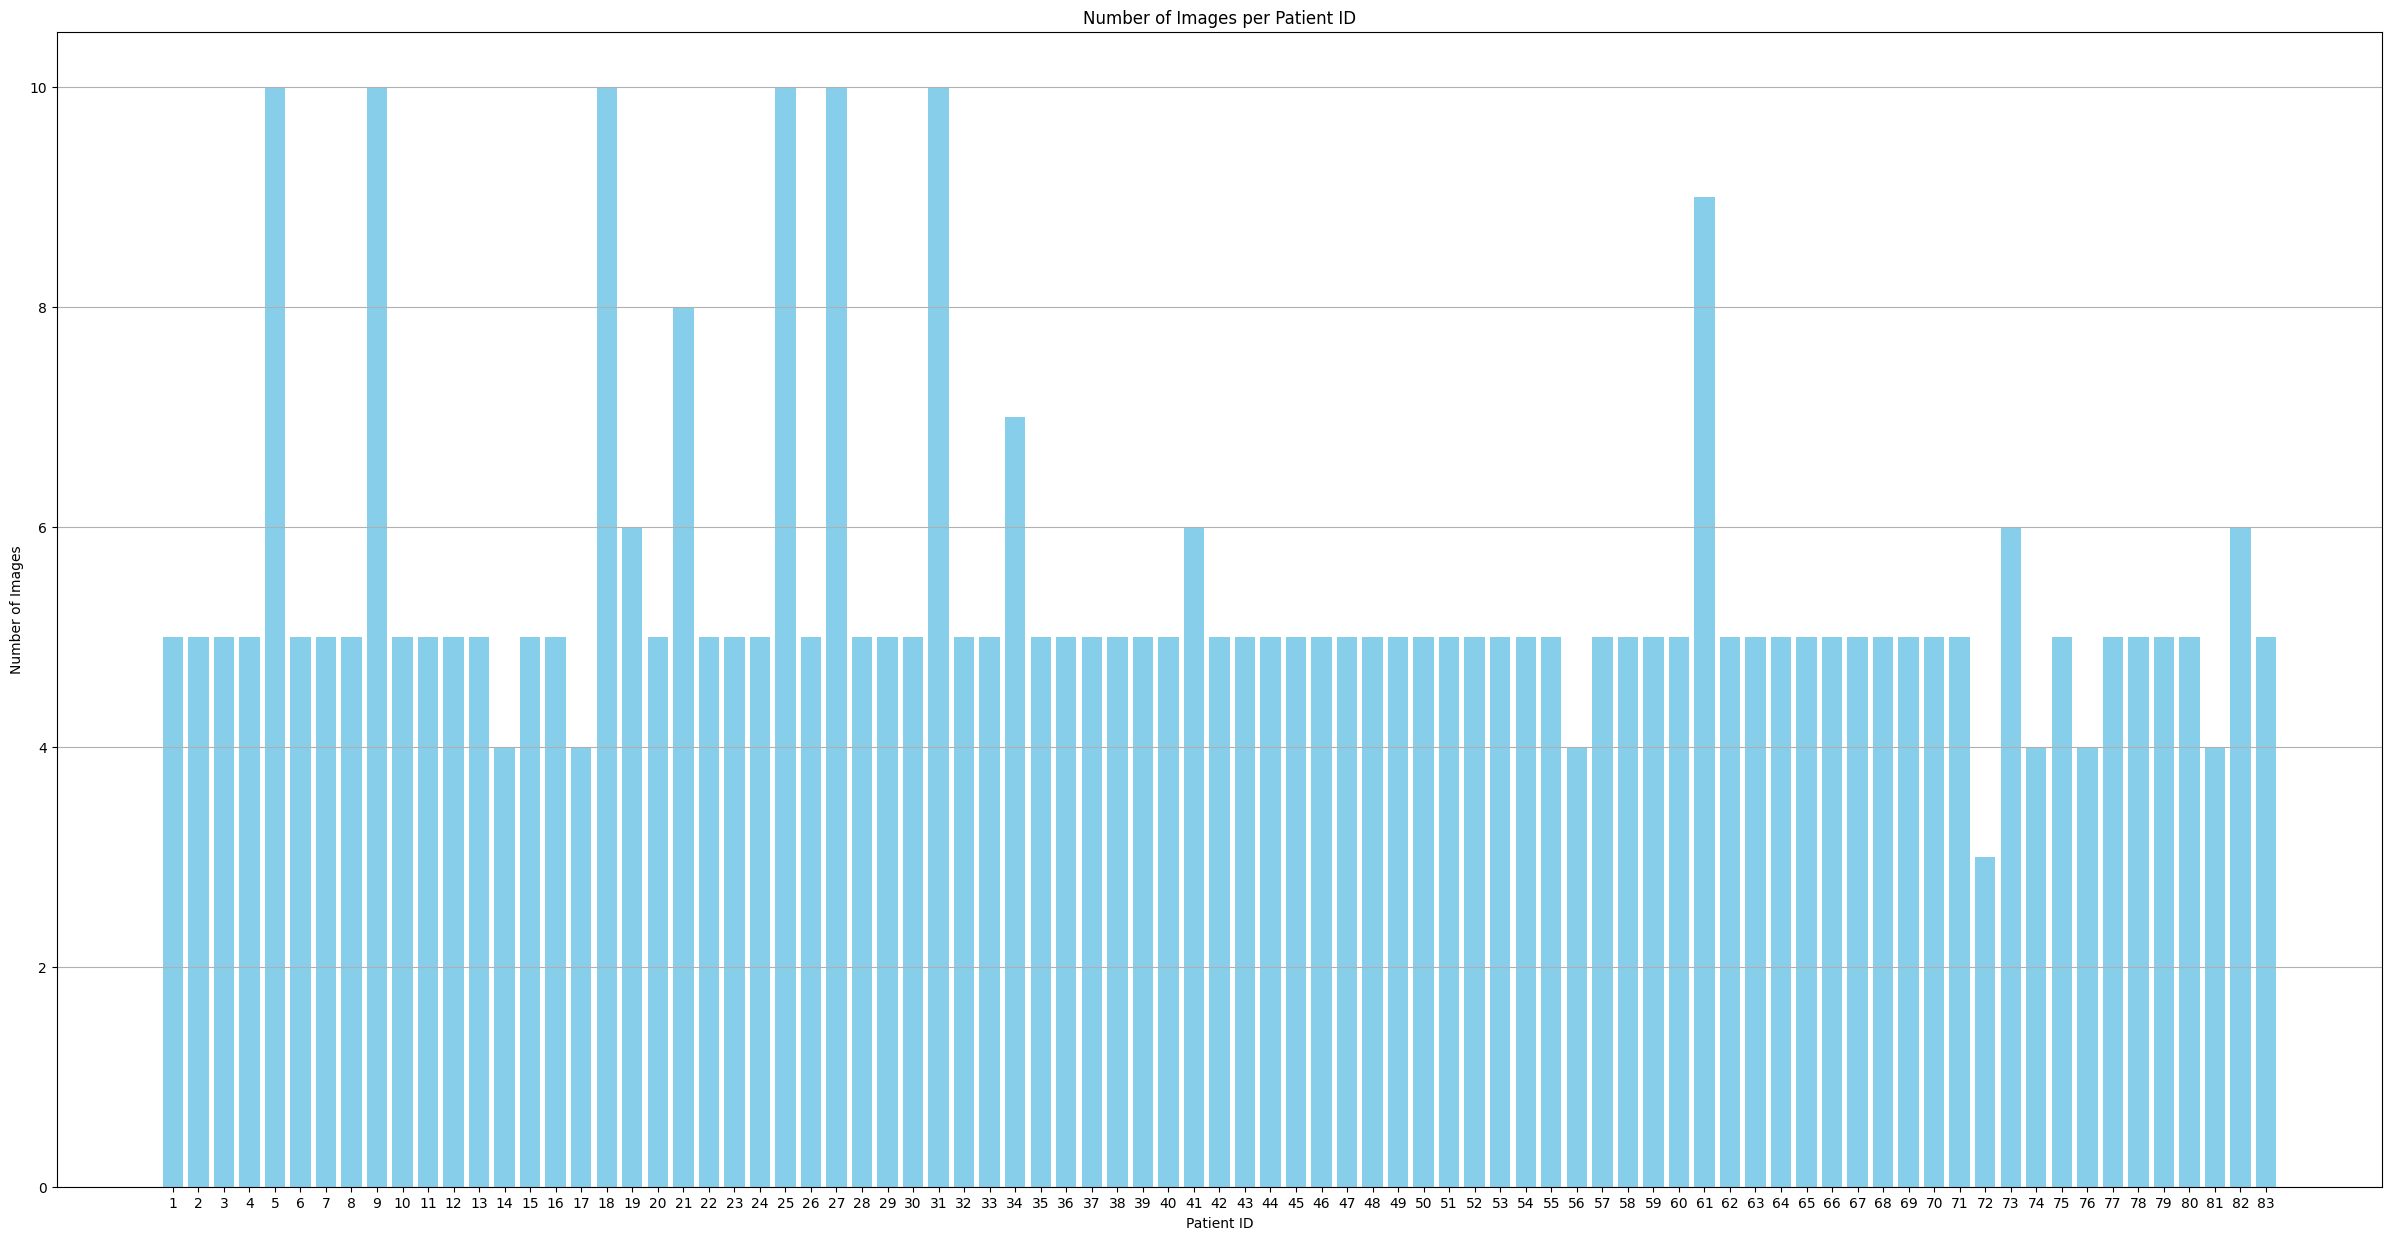

In [16]:
image_counts = df['patient_ID'].value_counts().sort_index()

plt.figure(figsize=(30, 15))
plt.bar(image_counts.index, image_counts.values, color='skyblue')
plt.xlabel('Patient ID')
plt.ylabel('Number of Images')
plt.title('Number of Images per Patient ID')
plt.xticks(image_counts.index)
plt.grid(axis='y')
plt.show()

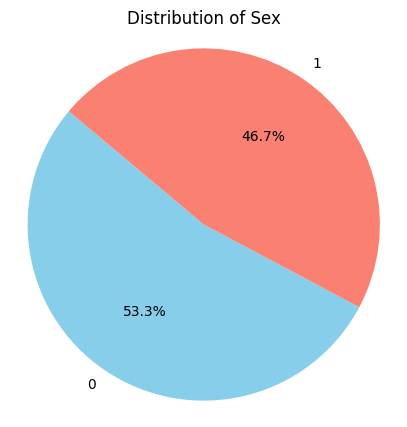

In [17]:
sex_counts = df['sex'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title('Distribution of Sex')
plt.axis('equal') 
plt.show()

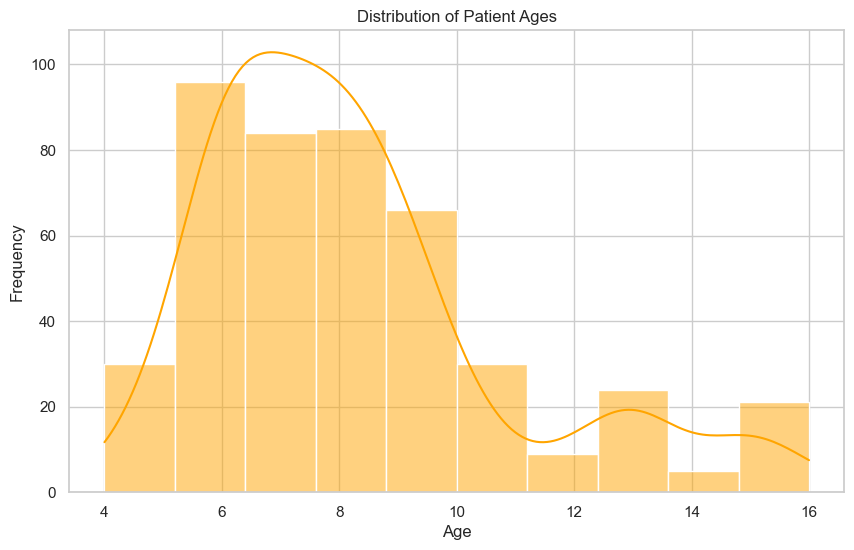

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df['age'].dropna(), bins=10, kde=True, color='orange')
plt.title('Distribution of Patient Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

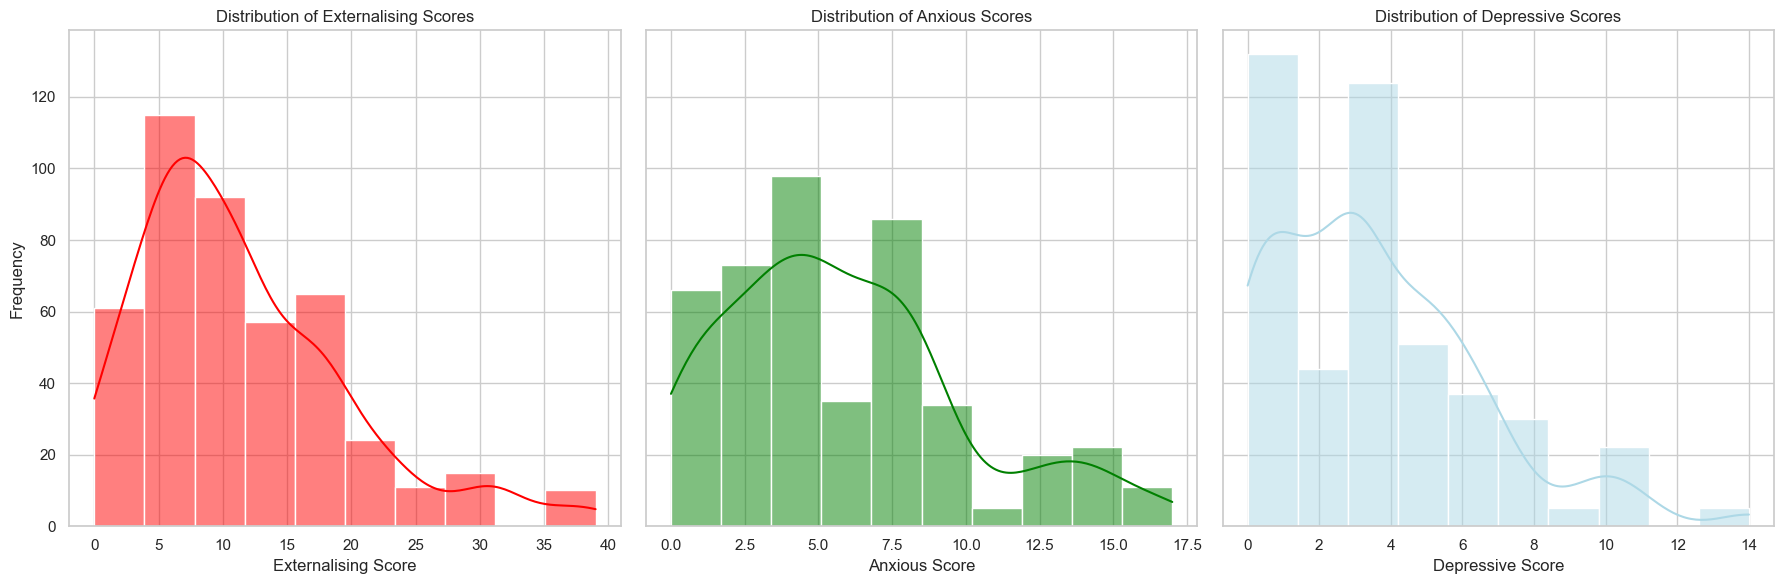

In [19]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

#externalising_score
sns.histplot(df['externalising_score'].dropna(), bins=10, kde=True, color='red', ax=axes[0])
axes[0].set_title('Distribution of Externalising Scores')
axes[0].set_xlabel('Externalising Score')
axes[0].set_ylabel('Frequency')

#anxious_score
sns.histplot(df['anxious_score'].dropna(), bins=10, kde=True, color='green', ax=axes[1])
axes[1].set_title('Distribution of Anxious Scores')
axes[1].set_xlabel('Anxious Score')

#depressive_score
sns.histplot(df['depressive_score'].dropna(), bins=10, kde=True, color='lightblue', ax=axes[2])
axes[2].set_title('Distribution of Depressive Scores')
axes[2].set_xlabel('Depressive Score')

plt.tight_layout()
plt.show()

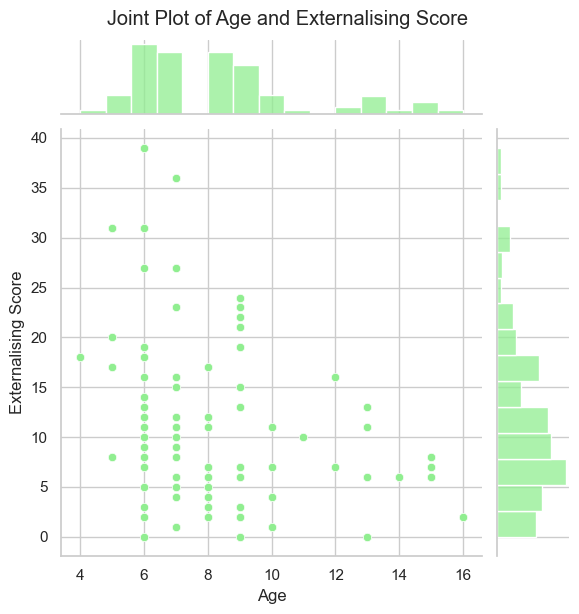

In [20]:
sns.jointplot(x='age', y='externalising_score', data=df, kind='scatter', color='lightgreen', marginal_kws=dict(bins=15, fill=True))
plt.suptitle('Joint Plot of Age and Externalising Score', y=1.02)
plt.xlabel('Age')
plt.ylabel('Externalising Score')
plt.show()

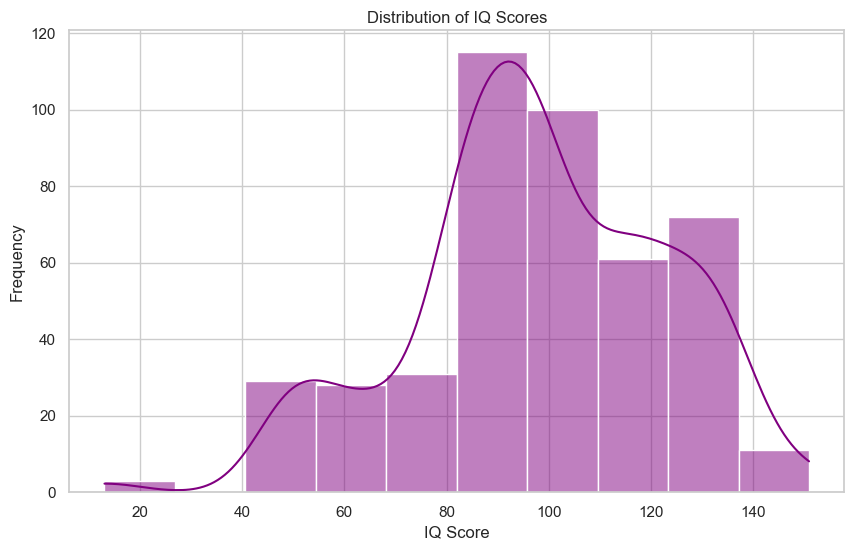

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df['iq_score'].dropna(), bins=10, kde=True, color='purple')
plt.title('Distribution of IQ Scores')
plt.xlabel('IQ Score')
plt.ylabel('Frequency')
plt.show()

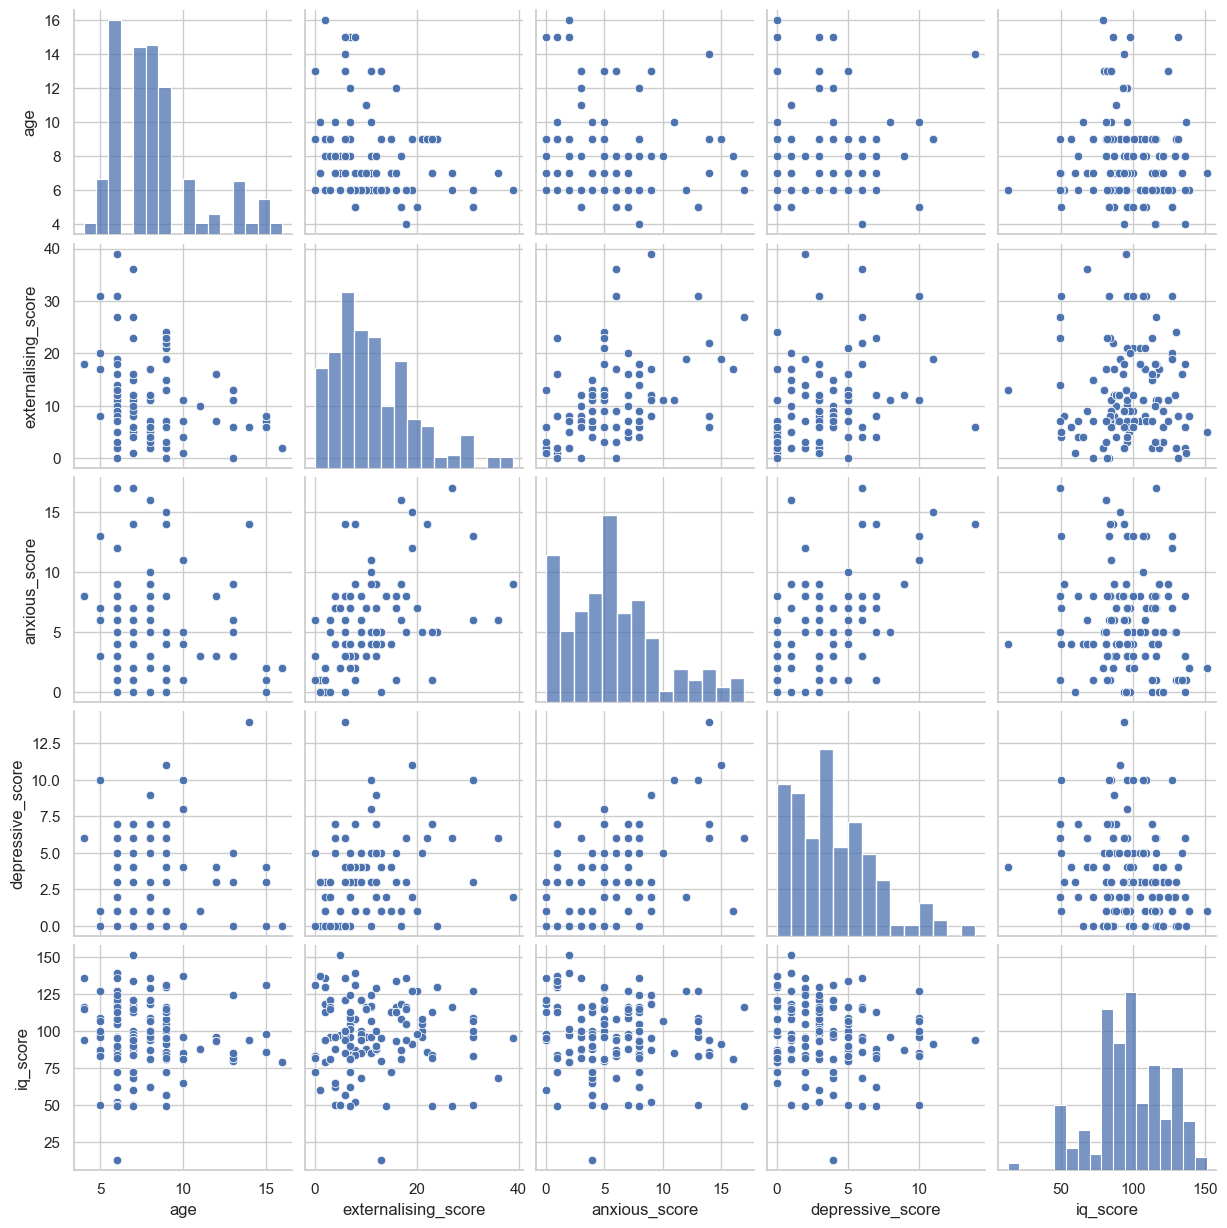

In [22]:
sns.pairplot(df[['age', 'externalising_score', 'anxious_score', 'depressive_score', 'iq_score']])
plt.show()

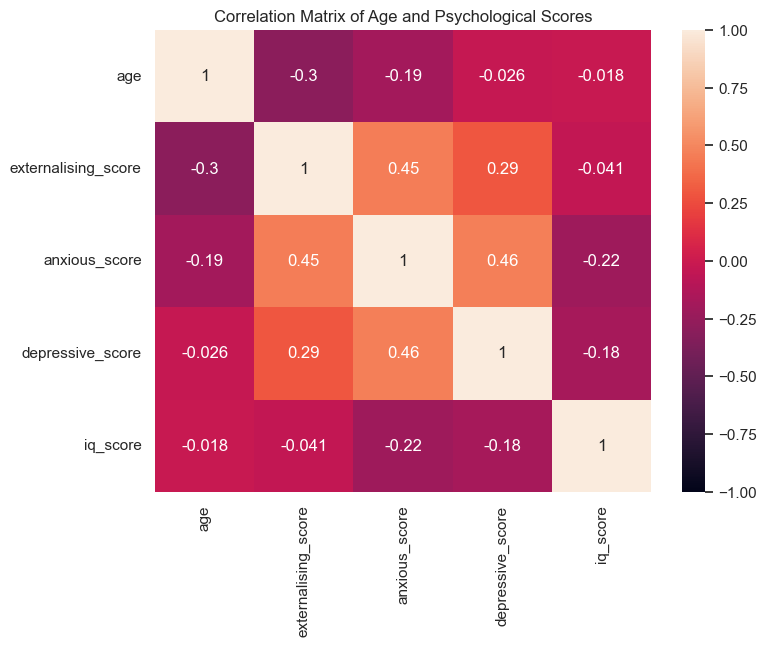

In [23]:
cols = ['age', 'externalising_score', 'anxious_score', 'depressive_score', 'iq_score']
corr_matrix = df[cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Age and Psychological Scores')
plt.show()

## Preprocessing

In [24]:
zip_file_path = 'son.zip'
extract_to = 'coco'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Zip file extracted successfully.")

Zip file extracted successfully.


In [25]:
coco_annotation_file = 'coco/result.json'

with open(coco_annotation_file, 'r') as f:
    coco_data = json.load(f)

print(f"Number of images in annotations: {len(coco_data['images'])}")
print(f"Number of annotations: {len(coco_data['annotations'])}")

for image_info in coco_data['images'][:5]: 
    print(f"Image ID: {image_info['id']}")
    print(f"File Name: {image_info['file_name']}")
    print(f"Image Path: {os.path.join('coco/images', image_info['file_name'])}")

    image_path = os.path.join('coco/images', image_info['file_name'])
    if not os.path.exists(image_path):
        print(f"Warning: Image file {image_info['file_name']} not found in coco/images directory.")

categories = coco_data['categories']
print("Categories:", categories)

Number of images in annotations: 450
Number of annotations: 391
Image ID: 0
File Name: images/1c119844-1_1.jpg
Image Path: coco/images/images/1c119844-1_1.jpg
Image ID: 1
File Name: images/8d434141-1_2.jpg
Image Path: coco/images/images/8d434141-1_2.jpg
Image ID: 2
File Name: images/fcc95ef8-1_3.jpg
Image Path: coco/images/images/fcc95ef8-1_3.jpg
Image ID: 3
File Name: images/d963802a-1_4.jpg
Image Path: coco/images/images/d963802a-1_4.jpg
Image ID: 4
File Name: images/debc84c6-1_5.jpg
Image Path: coco/images/images/debc84c6-1_5.jpg
Categories: [{'id': 0, 'name': 'house'}, {'id': 1, 'name': 'person'}, {'id': 2, 'name': 'tree'}]


In [26]:
coco_folder = 'coco'
htp_images_folder = 'HTPImages'

images_source = os.path.join(coco_folder, 'images')
images_destination = os.path.join(htp_images_folder, 'images')

if os.path.exists(images_source):
    if not os.path.exists(images_destination):
        os.makedirs(images_destination)
    for filename in os.listdir(images_source):
        src_file = os.path.join(images_source, filename)
        dst_file = os.path.join(images_destination, filename)
        shutil.move(src_file, dst_file)
    print(f"Moved images folder to {htp_images_folder}.")
else:
    print(f"{images_source} does not exist.")

results_file_source = os.path.join(coco_folder, 'result.json')
results_file_destination = os.path.join(htp_images_folder, 'result.json')

if os.path.exists(results_file_source):
    shutil.move(results_file_source, results_file_destination)
    print(f"Moved results.json to {htp_images_folder}.")
else:
    print(f"{results_file_source} does not exist.")

if os.path.exists(coco_folder):
    shutil.rmtree(coco_folder)
    print(f"Deleted the {coco_folder} folder.")
else:
    print(f"{coco_folder} folder does not exist.")

Moved images folder to HTPImages.
Moved results.json to HTPImages.
Deleted the coco folder.


In [27]:
images_subfolder = os.path.join(htp_images_folder, 'images')

for filename in os.listdir(htp_images_folder):
    file_path = os.path.join(htp_images_folder, filename)
    
    if os.path.isfile(file_path) and filename not in ['images', 'result.json']:
        shutil.move(file_path, os.path.join(images_subfolder, filename))

print("All images moved to the 'images' subfolder successfully.")

All images moved to the 'images' subfolder successfully.


In [28]:
coco_annotation_file = 'HTPImages/result.json'
images_folder = 'HTPImages/images'

with open(coco_annotation_file, 'r') as f:
    coco_data = json.load(f)

for image_info in coco_data['images']:
    base_filename = image_info['file_name'].split('-')[-1]
    
    image_info['file_name'] = base_filename

with open(coco_annotation_file, 'w') as f:
    json.dump(coco_data, f, indent=4)

print("File names in results.json have been updated successfully.")

missing_files = []
for image_info in coco_data['images']:
    image_path = os.path.join(images_folder, image_info['file_name'])
    if not os.path.exists(image_path):
        missing_files.append(image_info['file_name'])

if missing_files:
    print("The following image files are missing in the images folder:")
    for missing_file in missing_files:
        print(missing_file)
else:
    print("All images are present in the images folder.")

File names in results.json have been updated successfully.
All images are present in the images folder.


In [29]:
coco_annotation_file = 'HTPImages/result.json'

with open(coco_annotation_file, 'r') as f:
    coco_data = json.load(f)

print(f"Number of images in annotations: {len(coco_data['images'])}")
print(f"Number of annotations: {len(coco_data['annotations'])}")

for image_info in coco_data['images'][:5]: 
    print(f"Image ID: {image_info['id']}")
    print(f"File Name: {image_info['file_name']}")
    print(f"Image Path: {os.path.join('HTPImages/images', image_info['file_name'])}")

    image_path = os.path.join('HTPImages/images', image_info['file_name'])
    if not os.path.exists(image_path):
        print(f"Warning: Image file {image_info['file_name']} not found in HTPImages/images directory.")

categories = coco_data['categories']
print("Categories:", categories)

Number of images in annotations: 450
Number of annotations: 391
Image ID: 0
File Name: 1_1.jpg
Image Path: HTPImages/images/1_1.jpg
Image ID: 1
File Name: 1_2.jpg
Image Path: HTPImages/images/1_2.jpg
Image ID: 2
File Name: 1_3.jpg
Image Path: HTPImages/images/1_3.jpg
Image ID: 3
File Name: 1_4.jpg
Image Path: HTPImages/images/1_4.jpg
Image ID: 4
File Name: 1_5.jpg
Image Path: HTPImages/images/1_5.jpg
Categories: [{'id': 0, 'name': 'house'}, {'id': 1, 'name': 'person'}, {'id': 2, 'name': 'tree'}]


In [30]:
with open('HTPImages/result.json', 'r') as f:
    annotations = json.load(f)

image_dict = {img['id']: img['file_name'] for img in annotations['images']}

category_dict = {cat['id']: cat['name'] for cat in annotations['categories']}

'''
for ann in annotations['annotations'][:10]:
    image_id = ann['image_id']
    bbox = ann['bbox']  
    category_id = ann['category_id']
    category_name = category_dict[category_id]

    img_path = os.path.join('HTPImages/images', image_dict[image_id])
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x, y, w, h = bbox
    cv2.rectangle(img_rgb, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)
    cv2.putText(img_rgb, category_name, (int(x), int(y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(img_rgb)
    plt.title(f'Category: {category_name}')
    plt.axis('off')
    plt.show()
'''

"\nfor ann in annotations['annotations'][:10]:\n    image_id = ann['image_id']\n    bbox = ann['bbox']  \n    category_id = ann['category_id']\n    category_name = category_dict[category_id]\n\n    img_path = os.path.join('HTPImages/images', image_dict[image_id])\n    img = cv2.imread(img_path)\n    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n    x, y, w, h = bbox\n    cv2.rectangle(img_rgb, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)\n    cv2.putText(img_rgb, category_name, (int(x), int(y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)\n\n    plt.imshow(img_rgb)\n    plt.title(f'Category: {category_name}')\n    plt.axis('off')\n    plt.show()\n"

In [31]:
image_base_path = 'HTPImages/images'

for ann in annotations['annotations']:
    image_id = ann['image_id']
    bbox = ann['bbox']
    category_id = ann['category_id']
    category_name = category_dict[category_id]

    img_filename = image_dict[image_id]
    img_path = os.path.join(image_base_path, img_filename)

    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Image {img_filename} could not be loaded.")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Extract bounding box
    x, y, w, h = bbox

    # Crop the image using the box
    cropped_img = img[int(y):int(y + h), int(x):int(x + w)]
    cv2.imwrite(img_path, cropped_img)

print("Images have been cropped and saved successfully.")

Images have been cropped and saved successfully.


In [32]:
# RESIZE
image_folder = 'HTPImages/images'
target_size = (224, 224)

for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)
    if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(file_path)
        resized_img = cv2.resize(img, target_size)
        cv2.imwrite(file_path, resized_img)
print("Resizing completed and images updated in place.")

Resizing completed and images updated in place.


In [33]:
# NORMALIZE
def normalize_image(img):
    return img / 255.0

for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)
    if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(file_path)
        normalized_img = normalize_image(img)
        normalized_img = (normalized_img * 255).astype(np.uint8)
        cv2.imwrite(file_path, normalized_img)

print("Normalization completed and images updated in place.")

Normalization completed and images updated in place.


In [34]:
with open('HTPImages/result.json', 'r') as f:
    annotations = json.load(f)

image_dict = {img['file_name']: img['id'] for img in annotations['images']}
category_dict = {cat['id']: cat['name'] for cat in annotations['categories']}
annotation_dict = {ann['image_id']: category_dict[ann['category_id']] for ann in annotations['annotations']}

In [35]:
filename_to_label = {}
for image in annotations['images']:
    file_name = image['file_name']
    image_id = image['id']
    if image_id in annotation_dict:
        filename_to_label[file_name] = annotation_dict[image_id]

In [36]:
df['label'] = df['image_file'].map(filename_to_label)

print("Label column added to DataFrame and saved successfully.")

Label column added to DataFrame and saved successfully.


In [37]:
df

,image_file,patient_name,page_number,patient_ID,sex,age,externalising_score,anxious_score,depressive_score,iq_score,label
0,81_1.jpg,OFB,1,81,1,6,10.0,7.0,4.0,96.0,person
1,61_3.jpg,ES,3,61,1,6,10.0,7.0,4.0,116.0,person
2,44_2.jpg,REG,2,44,1,7,27.0,17.0,6.0,49.0,tree
3,8_1.jpg,AAA,1,8,1,6,9.0,5.0,3.0,121.0,house
4,45_1.jpg,NEŞ,1,45,0,8,3.0,6.0,2.0,96.0,house
...,...,...,...,...,...,...,...,...,...,...,...
445,35_3.jpg,BK,3,35,1,12,16.0,8.0,3.0,93.0,person
446,64_4.jpg,ARÖ,4,64,1,13,6.0,6.0,3.0,85.0,person
447,65_5.jpg,HP,5,65,0,7,10.0,7.0,1.0,115.0,person
448,2_5.jpg,YG,5,2,0,9,3.0,5.0,3.0,115.0,person


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image_file           450 non-null    object 
 1   patient_name         450 non-null    object 
 2   page_number          450 non-null    object 
 3   patient_ID           450 non-null    int64  
 4   sex                  450 non-null    int64  
 5   age                  450 non-null    int64  
 6   externalising_score  450 non-null    float64
 7   anxious_score        450 non-null    float64
 8   depressive_score     450 non-null    float64
 9   iq_score             450 non-null    float64
 10  label                390 non-null    object 
dtypes: float64(4), int64(3), object(4)
memory usage: 38.8+ KB


In [39]:
df = df.dropna(subset=['label'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 0 to 449
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image_file           390 non-null    object 
 1   patient_name         390 non-null    object 
 2   page_number          390 non-null    object 
 3   patient_ID           390 non-null    int64  
 4   sex                  390 non-null    int64  
 5   age                  390 non-null    int64  
 6   externalising_score  390 non-null    float64
 7   anxious_score        390 non-null    float64
 8   depressive_score     390 non-null    float64
 9   iq_score             390 non-null    float64
 10  label                390 non-null    object 
dtypes: float64(4), int64(3), object(4)
memory usage: 36.6+ KB
None


In [40]:
image_folder = 'HTPImages/images'

labelled_images = df['image_file'].tolist()

for filename in os.listdir(image_folder):
    if filename not in labelled_images:
        file_path = os.path.join(image_folder, filename)
        os.remove(file_path)
        print(f"Removed unlabelled image: {filename}")

remaining_images = os.listdir(image_folder)
print(f"Number of remaining labelled images: {len(remaining_images)}")

Removed unlabelled image: 21_8.jpg
Removed unlabelled image: 34_1.jpg
Removed unlabelled image: 18_8.jpg
Removed unlabelled image: 25_8.jpg
Removed unlabelled image: 73_2.jpg
Removed unlabelled image: 27_8.jpg
Removed unlabelled image: 34_2.jpg
Removed unlabelled image: 8_5.jpg
Removed unlabelled image: 9_10.jpg
Removed unlabelled image: 8_4.jpg
Removed unlabelled image: 5_10.jpg
Removed unlabelled image: 28_1.jpg
Removed unlabelled image: 18_10.jpg
Removed unlabelled image: 9_2.jpg
Removed unlabelled image: 28_2.jpg
Removed unlabelled image: 28_3.jpg
Removed unlabelled image: 31_2.jpg
Removed unlabelled image: 31_6.jpg
Removed unlabelled image: 5_8.jpg
Removed unlabelled image: 9_4.jpg
Removed unlabelled image: 9_6.jpg
Removed unlabelled image: 28_4.jpg
Removed unlabelled image: 72_3.jpg
Removed unlabelled image: 28_5.jpg
Removed unlabelled image: 31_4.jpg
Removed unlabelled image: 31_9.jpg
Removed unlabelled image: 25_10.jpg
Removed unlabelled image: 24_5.jpg
Removed unlabelled image

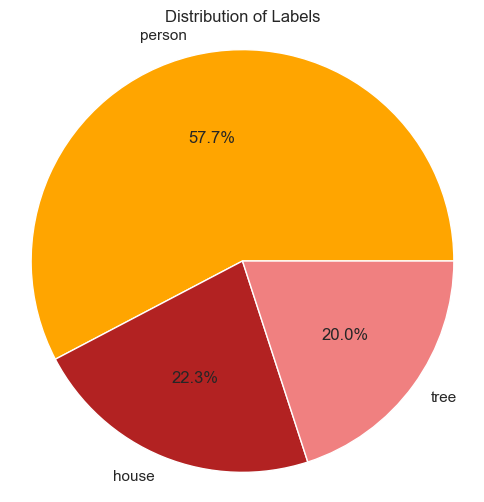

Number of images for each label:
label
person    225
house      87
tree       78
Name: count, dtype: int64


In [41]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['orange','firebrick','lightcoral' ])
plt.title('Distribution of Labels')
plt.axis('equal')
plt.show()

print("Number of images for each label:")
print(label_counts)

In [42]:
qd = QuickDrawData()
categories = qd.drawing_names
print(categories)

['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'diving board', 'dog', 'dolphin', 

In [43]:
base_dir = "HTPImages"
feature_dir = os.path.join(base_dir, "feature")

categories = {
    "house": QuickDrawDataGroup("house"),
    "tree": QuickDrawDataGroup("tree"),
    "face": QuickDrawDataGroup("face")
}

for category in categories.keys():
    folder_name = "person" if category == "face" else category 
    subfolder_path = os.path.join(feature_dir, folder_name)
    os.makedirs(subfolder_path, exist_ok=True)

for category, data_group in categories.items():
    folder_name = "person" if category == "face" else category
    folder_path = os.path.join(feature_dir, folder_name)

    for i in range(500):
        drawing = data_group.get_drawing()
        image = drawing.image.convert("RGB")
        image_path = os.path.join(folder_path, f"{category}_{i+1}.jpg")
        image.save(image_path, "JPEG")

    print(f"500 {category} images from QuickDraw have been saved to '{folder_path}' in JPEG format.")

print("All images have been saved.")

loading house drawings
load complete
loading tree drawings
load complete
loading face drawings
load complete
500 house images from QuickDraw have been saved to 'HTPImages/feature/house' in JPEG format.
500 tree images from QuickDraw have been saved to 'HTPImages/feature/tree' in JPEG format.
500 face images from QuickDraw have been saved to 'HTPImages/feature/person' in JPEG format.
All images have been saved.


In [44]:
base_dir = "HTPImages"
images_folder = os.path.join(base_dir, "images")
feature_dir = os.path.join(base_dir, "feature")
annotations_file = os.path.join(base_dir, "result.json")

for category_name in category_dict.values():
    subfolder_path = os.path.join(feature_dir, category_name)
    os.makedirs(subfolder_path, exist_ok=True)

for annotation in annotations['annotations']:
    image_id = annotation['image_id']
    category_id = annotation['category_id']
    category_name = category_dict[category_id]

    image_info = next(img for img in annotations['images'] if img['id'] == image_id)
    image_filename = image_info['file_name']
    image_path = os.path.join(images_folder, image_filename)

    dest_path = os.path.join(feature_dir, category_name, image_filename)

    shutil.copy(image_path, dest_path)

print("All images have been copied to the appropriate subfolders in the 'feature' directory.")

All images have been copied to the appropriate subfolders in the 'feature' directory.


Number of images in 'house': 587
Number of images in 'tree': 578
Number of images in 'person': 725


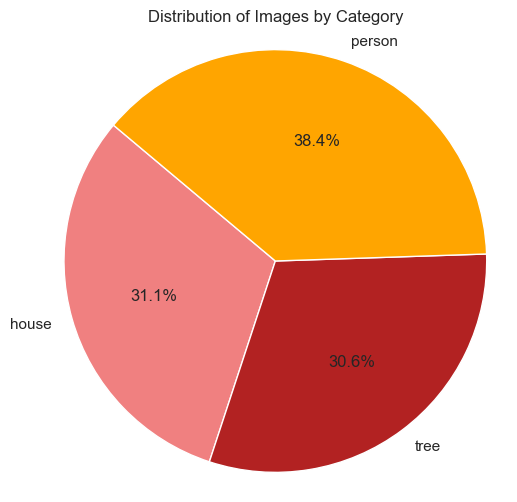

In [45]:
base_dir = os.path.join("HTPImages", "feature")
subfolders = ["house", "tree", "person"]

counts = {}
for subfolder in subfolders:
    folder_path = os.path.join(base_dir, subfolder)
    if os.path.exists(folder_path):
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        num_files = len(files)
        counts[subfolder] = num_files
        print(f"Number of images in '{subfolder}': {num_files}")
    else:
        counts[subfolder] = 0
        print(f"Folder '{subfolder}' does not exist.")

labels = counts.keys()
sizes = counts.values()
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'firebrick', 'orange'])
plt.title('Distribution of Images by Category')
plt.axis('equal')
plt.show()

In [46]:
target_size = (224, 224)

def preprocess_image(img_path, target_size):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return img_array

In [47]:
def get_images(directory):
    images = []
    labels = []
    
    directory = directory if directory.endswith(os.path.sep) else directory + os.path.sep
    
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (224, 224))
                    image = image / 255.0
                    
                    images.append(image)
                    labels.append(label)
    
    return shuffle(images, labels, random_state=817328462)

In [48]:
images, labels = get_images("./HTPImages/feature/")

images = np.array(images)
labels = np.array(labels)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

label_counts = Counter(encoded_labels)
print("Label distribution:", label_counts)

class_weights = compute_class_weight('balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)

Label distribution: Counter({1: 725, 0: 587, 2: 578})
Class Weights: {0: 1.0732538330494037, 1: 0.8689655172413793, 2: 1.0899653979238755}


## Model Implementation & Evaluation

### Stage 1

#### ResNet50

In [49]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = resnet_base.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

for layer in resnet_base.layers[:-10]:
    layer.trainable = False

for layer in resnet_base.layers[-10:]:
    layer.trainable = True

resnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [50]:
start_time_resnet = time.time()
training_history_resnet = resnet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, class_weight=class_weight_dict)
train_time_resnet = time.time() - start_time_resnet

Epoch 1/10


2024-07-27 11:06:49.105097: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


48/48 [==============================] - 70s 1s/step - loss: 0.4203 - accuracy: 0.8287 - val_loss: 0.5130 - val_accuracy: 0.7566
Epoch 2/10
48/48 [==============================] - 68s 1s/step - loss: 0.1851 - accuracy: 0.9272 - val_loss: 0.4966 - val_accuracy: 0.7513
Epoch 3/10
48/48 [==============================] - 67s 1s/step - loss: 0.1340 - accuracy: 0.9438 - val_loss: 0.4111 - val_accuracy: 0.8042
Epoch 4/10
48/48 [==============================] - 67s 1s/step - loss: 0.1295 - accuracy: 0.9478 - val_loss: 0.3213 - val_accuracy: 0.8545
Epoch 5/10
48/48 [==============================] - 68s 1s/step - loss: 0.1514 - accuracy: 0.9405 - val_loss: 0.3611 - val_accuracy: 0.8148
Epoch 6/10
48/48 [==============================] - 64s 1s/step - loss: 0.1015 - accuracy: 0.9597 - val_loss: 0.2627 - val_accuracy: 0.8757
Epoch 7/10
48/48 [==============================] - 65s 1s/step - loss: 0.1011 - accuracy: 0.9610 - val_loss: 0.2293 - val_accuracy: 0.9153
Epoch 8/10
48/48 [=============

12/12 [==============================] - 11s 871ms/step
F1 Score: 0.9029351051301191
Recall: 0.9021164021164021
Precision: 0.9121078738145996
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94       115
           1       0.93      0.85      0.89       135
           2       0.82      0.98      0.89       128

    accuracy                           0.90       378
   macro avg       0.91      0.90      0.90       378
weighted avg       0.91      0.90      0.90       378

Training Time: 669.1155331134796
Prediction Time: 11.514450788497925


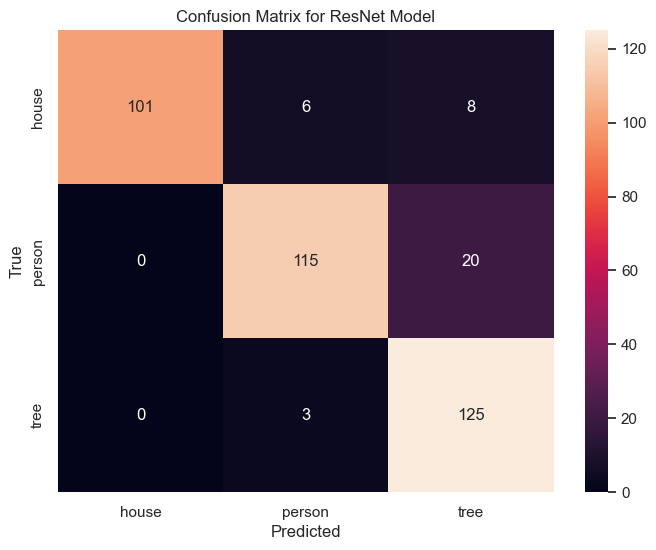

In [51]:
start_time_resnet = time.time()
y_pred = np.argmax(resnet_model.predict(X_test), axis=1)
predict_time_resnet = time.time() - start_time_resnet

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Training Time:", train_time_resnet)
print("Prediction Time:", predict_time_resnet)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ResNet Model')
plt.show()

12/12 [==============================] - 10s 851ms/step - loss: 0.2391 - accuracy: 0.9021
Train accuracy: 0.9609788656234741
Test accuracy: 0.9021164178848267


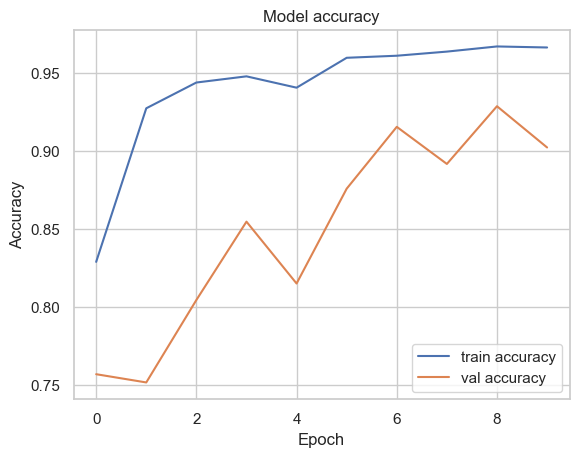

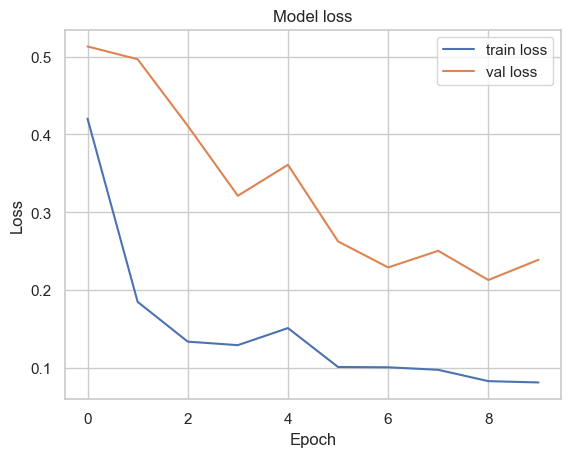

In [52]:
train_loss, train_accuracy = resnet_model.evaluate(X_train, y_train)
test_loss, test_accuracy = resnet_model.evaluate(X_test, y_test)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

plt.plot(training_history_resnet.history['accuracy'], label='train accuracy')
plt.plot(training_history_resnet.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(training_history_resnet.history['loss'], label='train loss')
plt.plot(training_history_resnet.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#### VGG16

In [53]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = vgg_base.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

vgg_model = Model(inputs=vgg_base.input, outputs=predictions)

for layer in vgg_base.layers[:-10]:
    layer.trainable = False

for layer in vgg_base.layers[-10:]:
    layer.trainable = True

vgg_model.compile(optimizer=Adam(learning_rate=1e-5), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [54]:
start_time_vgg = time.time()
training_history_vgg = vgg_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, class_weight=class_weight_dict)
train_time_vgg = time.time() - start_time_vgg

Epoch 1/10
48/48 [==============================] - 289s 6s/step - loss: 0.3956 - accuracy: 0.8545 - val_loss: 0.1568 - val_accuracy: 0.9392
Epoch 2/10
48/48 [==============================] - 289s 6s/step - loss: 0.0681 - accuracy: 0.9749 - val_loss: 0.1148 - val_accuracy: 0.9550
Epoch 3/10
48/48 [==============================] - 289s 6s/step - loss: 0.0216 - accuracy: 0.9947 - val_loss: 0.1027 - val_accuracy: 0.9630
Epoch 4/10
48/48 [==============================] - 292s 6s/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0870 - val_accuracy: 0.9656
Epoch 5/10
48/48 [==============================] - 295s 6s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0884 - val_accuracy: 0.9683
Epoch 6/10
48/48 [==============================] - 294s 6s/step - loss: 9.3155e-04 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 0.9656
Epoch 7/10
48/48 [==============================] - 299s 6s/step - loss: 5.9485e-04 - accuracy: 1.0000 - val_loss: 0.0896 - val_accuracy: 0.9656
Epoch

12/12 [==============================] - 32s 3s/step
F1 Score: 0.9682497960069212
Recall: 0.9682539682539683
Precision: 0.9682662222548996
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       115
           1       0.97      0.96      0.97       135
           2       0.97      0.97      0.97       128

    accuracy                           0.97       378
   macro avg       0.97      0.97      0.97       378
weighted avg       0.97      0.97      0.97       378

Training Time: 2926.990546941757
Prediction Time: 32.142778158187866


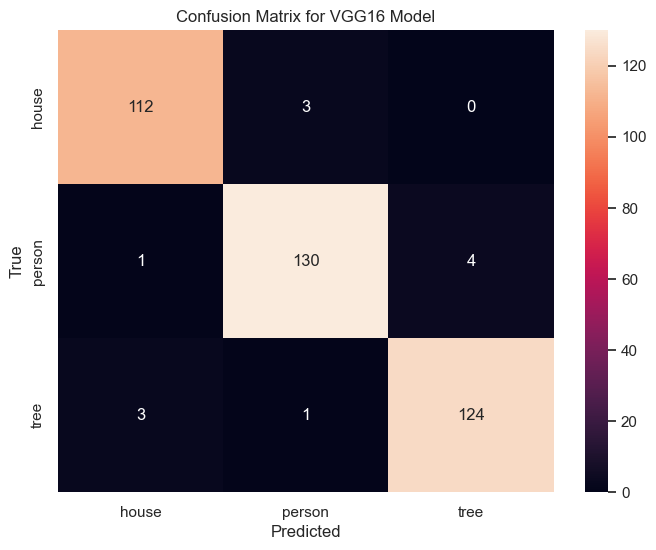

In [55]:
start_time_vgg = time.time()
y_pred = np.argmax(vgg_model.predict(X_test), axis=1)
predict_time_vgg = time.time() - start_time_vgg

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Training Time:", train_time_vgg)
print("Prediction Time:", predict_time_vgg)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for VGG16 Model')
plt.show()

12/12 [==============================] - 32s 3s/step - loss: 0.0925 - accuracy: 0.9683
Train accuracy: 1.0
Test accuracy: 0.9682539701461792


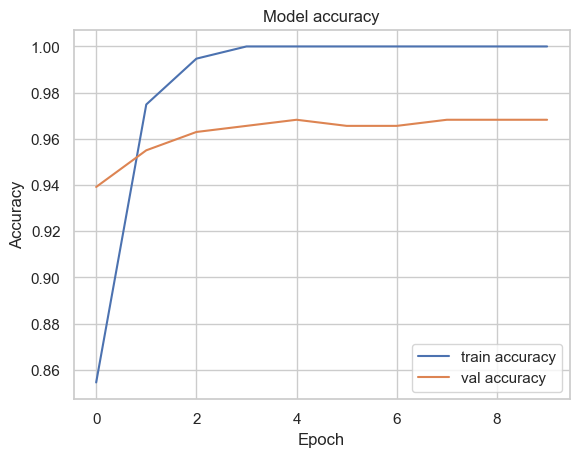

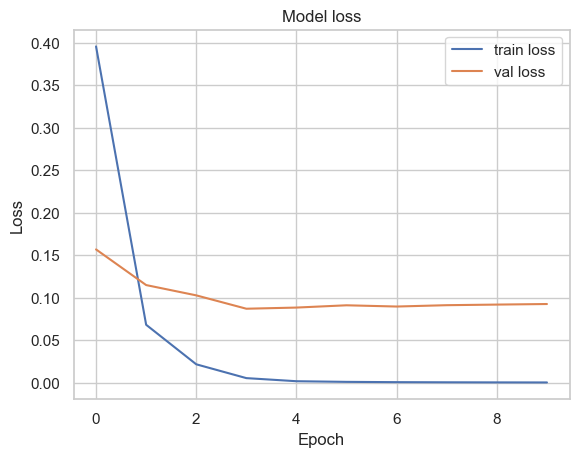

In [56]:
train_loss, train_accuracy = vgg_model.evaluate(X_train, y_train)
test_loss, test_accuracy = vgg_model.evaluate(X_test, y_test)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

# Plot training history
plt.plot(training_history_vgg.history['accuracy'], label='train accuracy')
plt.plot(training_history_vgg.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(training_history_vgg.history['loss'], label='train loss')
plt.plot(training_history_vgg.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#### EfficientNet

In [57]:
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = efficientnet_base.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

efficientnet_model = Model(inputs=efficientnet_base.input, outputs=predictions)

for layer in efficientnet_base.layers[:-10]:
    layer.trainable = False

for layer in efficientnet_base.layers[-10:]:
    layer.trainable = True

efficientnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

efficientnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']    

In [58]:
start_time_effnet = time.time()
training_history_efficientnet = efficientnet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, class_weight=class_weight_dict)
train_time_effnet = time.time() - start_time_effnet

Epoch 1/10
48/48 [==============================] - 31s 590ms/step - loss: 1.2022 - accuracy: 0.3393 - val_loss: 1.1056 - val_accuracy: 0.3571
Epoch 2/10
48/48 [==============================] - 26s 546ms/step - loss: 1.1210 - accuracy: 0.3472 - val_loss: 1.1059 - val_accuracy: 0.3571
Epoch 3/10
48/48 [==============================] - 26s 538ms/step - loss: 1.1149 - accuracy: 0.3578 - val_loss: 1.0983 - val_accuracy: 0.3571
Epoch 4/10
48/48 [==============================] - 26s 539ms/step - loss: 1.0928 - accuracy: 0.4048 - val_loss: 1.0920 - val_accuracy: 0.3571
Epoch 5/10
48/48 [==============================] - 27s 564ms/step - loss: 1.0880 - accuracy: 0.4067 - val_loss: 1.0899 - val_accuracy: 0.5503
Epoch 6/10
48/48 [==============================] - 27s 554ms/step - loss: 1.0712 - accuracy: 0.4583 - val_loss: 1.1145 - val_accuracy: 0.3386
Epoch 7/10
48/48 [==============================] - 26s 545ms/step - loss: 1.0413 - accuracy: 0.4464 - val_loss: 1.1018 - val_accuracy: 0.3810

12/12 [==============================] - 5s 348ms/step
F1 Score: 0.440973034347333
Recall: 0.5396825396825397
Precision: 0.40720974062139476
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.69      0.57      0.62       135
           2       0.48      0.99      0.64       128

    accuracy                           0.54       378
   macro avg       0.39      0.52      0.42       378
weighted avg       0.41      0.54      0.44       378

Training Time: 267.2111029624939
Prediction Time: 4.997212886810303


/Users/iremhatipoglu/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iremhatipoglu/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iremhatipoglu/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

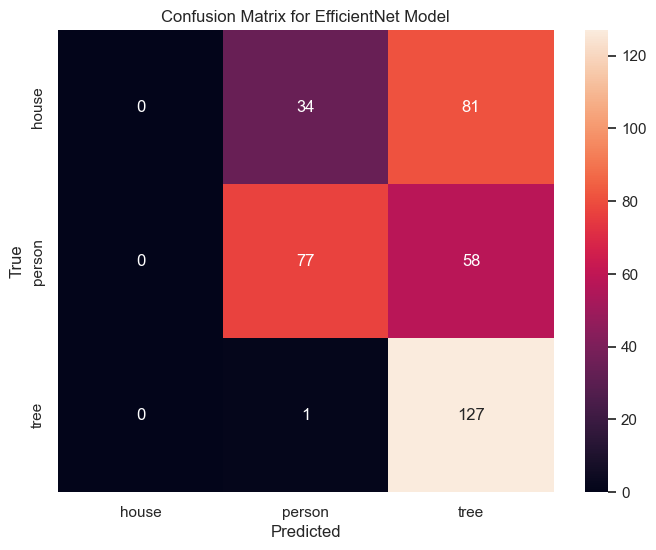

In [59]:
start_time_effnet = time.time()
y_pred = np.argmax(efficientnet_model.predict(X_test), axis=1)
predict_time_effnet = time.time() - start_time_effnet

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Training Time:", train_time_effnet)
print("Prediction Time:", predict_time_effnet)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for EfficientNet Model')
plt.show()

12/12 [==============================] - 4s 331ms/step - loss: 0.9998 - accuracy: 0.5397
Train accuracy: 0.5152116417884827
Test accuracy: 0.5396825671195984


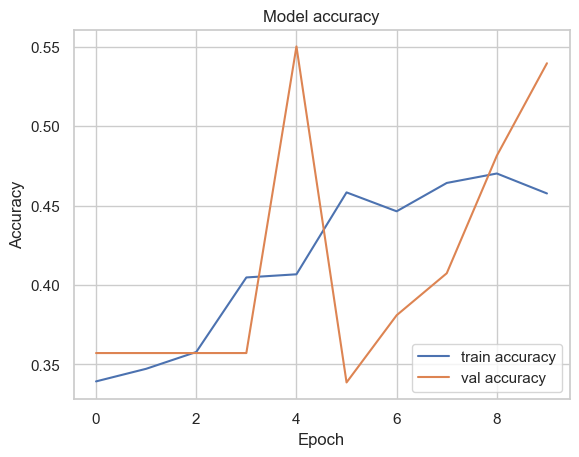

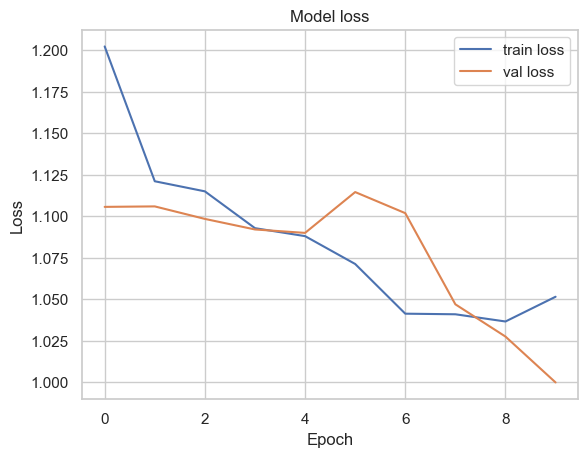

In [60]:
train_loss, train_accuracy = efficientnet_model.evaluate(X_train, y_train)
test_loss, test_accuracy = efficientnet_model.evaluate(X_test, y_test)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

# Plot training history
plt.plot(training_history_efficientnet.history['accuracy'], label='train accuracy')
plt.plot(training_history_efficientnet.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(training_history_efficientnet.history['loss'], label='train loss')
plt.plot(training_history_efficientnet.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [61]:
def evaluate_model(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print(classification_report(y_test, y_pred))

print("VGG16 Model Performance")
evaluate_model(vgg_model, X_test, y_test)

print("ResNet50 Model Performance")
evaluate_model(resnet_model, X_test, y_test)

print("EfficientNet Model Performance")
evaluate_model(efficientnet_model, X_test, y_test)

VGG16 Model Performance
12/12 [==============================] - 32s 3s/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       115
           1       0.97      0.96      0.97       135
           2       0.97      0.97      0.97       128

    accuracy                           0.97       378
   macro avg       0.97      0.97      0.97       378
weighted avg       0.97      0.97      0.97       378

ResNet50 Model Performance
12/12 [==============================] - 12s 885ms/step
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       115
           1       0.93      0.85      0.89       135
           2       0.82      0.98      0.89       128

    accuracy                           0.90       378
   macro avg       0.91      0.90      0.90       378
weighted avg       0.91      0.90      0.90       378

EfficientNet Model Performance
12/12 [==============================] - 4s 338

/Users/iremhatipoglu/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iremhatipoglu/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iremhatipoglu/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [62]:
training_histories = {
    'VGG16': training_history_vgg,
    'ResNet50': training_history_resnet,
    'EfficientNetB0': training_history_efficientnet
}

In [63]:
def plot_training_history(histories, metric='accuracy'):
    plt.figure(figsize=(12, 8))
    
    for model, history in histories.items():
        plt.plot(history.history[metric], label=f'{model} Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'{model} Validation {metric.capitalize()}')

    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

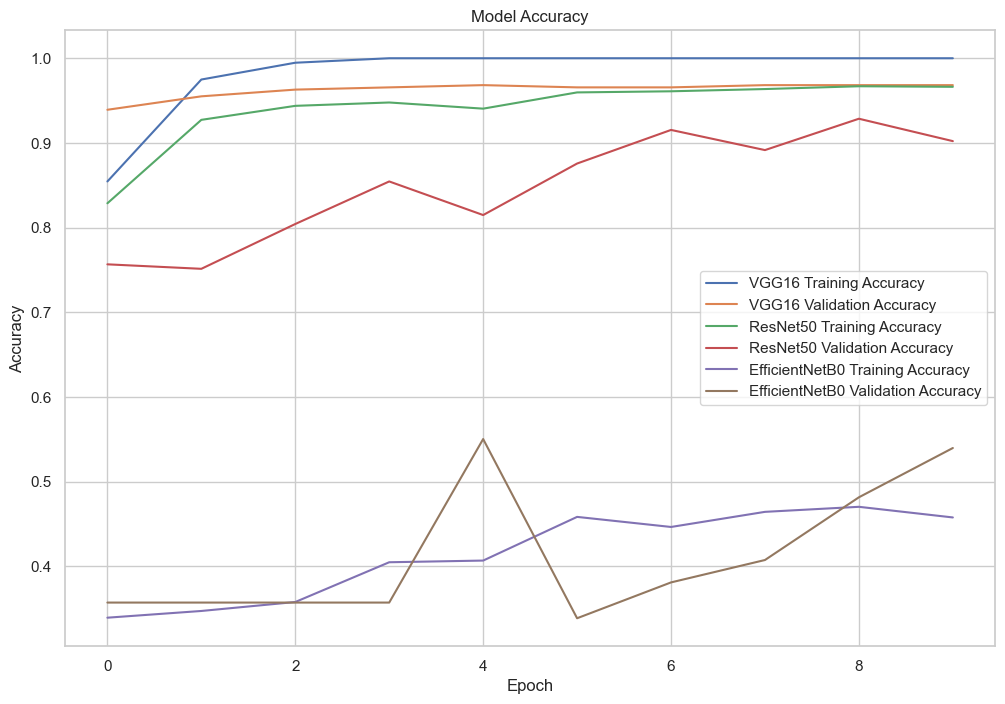

In [64]:
plot_training_history(training_histories, metric='accuracy')

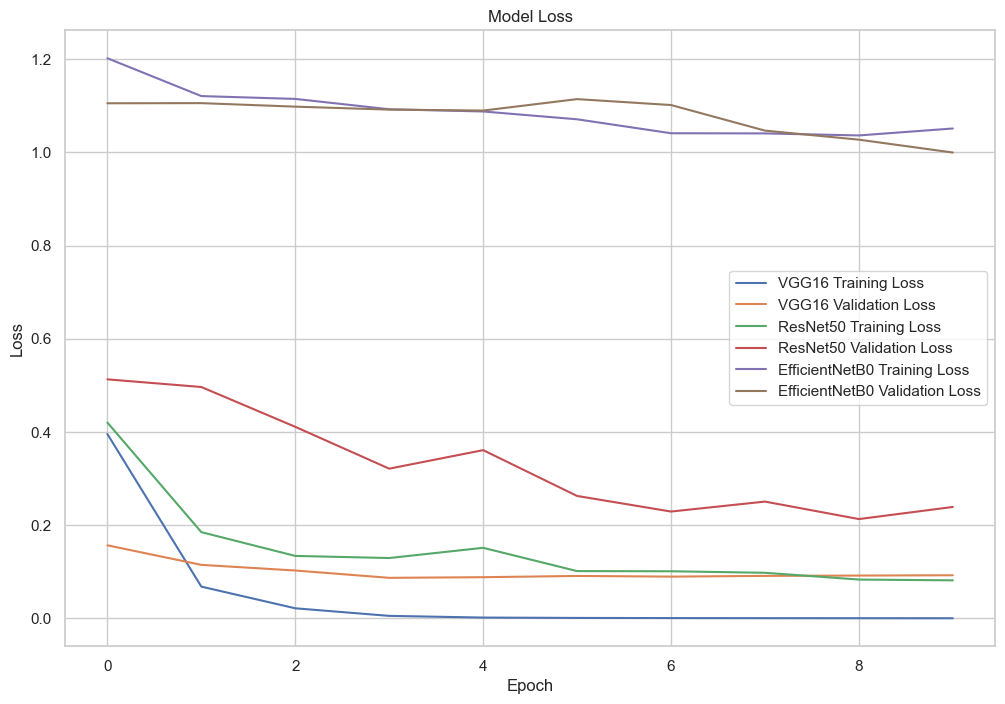

In [65]:
plot_training_history(training_histories, metric='loss')

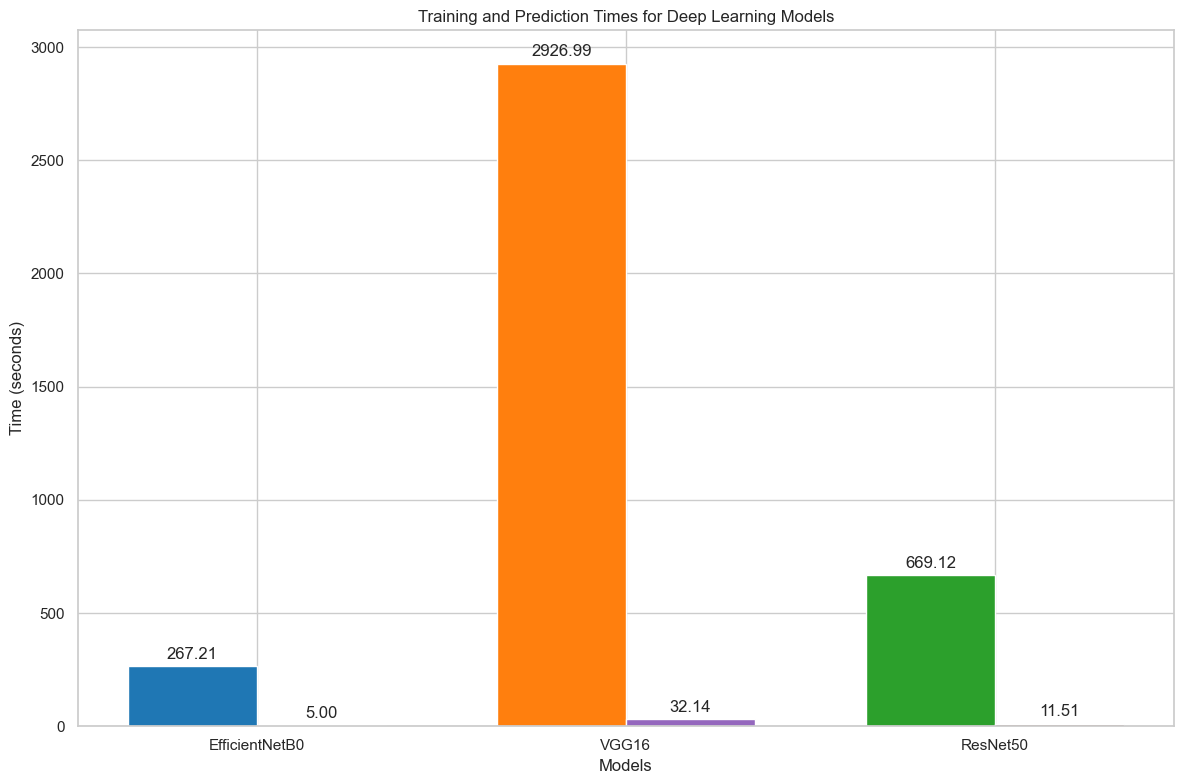

In [66]:
dl_models_names = ['EfficientNetB0', 'VGG16', 'ResNet50']
train_times = [train_time_effnet, train_time_vgg, train_time_resnet]
predict_times = [predict_time_effnet, predict_time_vgg, predict_time_resnet]

train_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
predict_colors = ['#d62728', '#9467bd', '#8c564b'] 

x = np.arange(len(dl_models_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width/2, train_times, width, color=train_colors)
rects2 = ax.bar(x + width/2, predict_times, width, color=predict_colors)

ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training and Prediction Times for Deep Learning Models')
ax.set_xticks(x)
ax.set_xticklabels(dl_models_names)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

In [67]:
model_save_path = "vgg_model.h5"
vgg_model.save(model_save_path)

### Stage 2

In [79]:
loaded_model = load_model(model_save_path)